#  Bank customer churn classification 
## Exploratory data analysis

In [1]:
import pandas as pd

In [2]:
# load config file 
import yaml
with open("../params.yaml", "r") as f:
    params = yaml.safe_load(f)

print(params)

{'base': {'project': 'bank_customer_churn', 'random_state': 0}, 'data': {'raw_data_dir': 'data/raw', 'data_file_name': 'Churn_Modelling.csv', 'cat_cols': ['Geography', 'Gender'], 'num_cols': ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], 'target_col': 'Exited'}, 'data_split': {'processed_data_dir': 'data/processed', 'test_size': 0.2}, 'train': {'model_dir': 'models', 'model_type': 'XGBClassifier', 'train_params': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}}, 'eval': {'model_path': 'models/model.pkl', 'reports_dir': 'reports', 'metrics_fname': 'metrics.json'}}


In [6]:
%cd ..

/Users/rihabfeki/Desktop/customer-churn-dvc


In [4]:
from pathlib import Path
import os

path = os.path.join(params['data']['raw_data_dir'], params['data']['data_file_name'])
path = Path(path)
path

PosixPath('data/raw/Churn_Modelling.csv')

In [9]:
# load datafarme
data = pd.read_csv(path)

In [25]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# target column count 
data['Exited'].value_counts()

In [10]:
# statistical overview of the data
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [11]:
# checking null values 
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
# list of categorical features 
cat_features = [i for i in data.columns if data.dtypes[i]=='object']
cat_features

['Surname', 'Geography', 'Gender']

In [13]:
# list of numerical features
num_features = [i for i in data.columns if data.dtypes[i]!='object']
num_features

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

## Pipeline: Preporcessing & training 

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

In [15]:
# The columns to be use to train the model
cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'

In [16]:
# set up training data
X = data[cat_cols + num_cols]
y = data[targ_col]

In [17]:
# train-test split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

The Scikit-learn library has tools called Pipeline and ColumnTransformer that can make data cleaning and preprocessing and model training easier. Instead of transforming the dataframe step by step (using difference cells in Jupyter Notebook), the pipeline combines all transformation steps. You can get the same result with less code and have in addition a clearer overview over the workflow. 

- Use the Pipeline for multiple transformations of the same columns.

- Use ColumnTransformer to transform each column set separately before combining them later.

In [18]:
# Create Pipelines for Numerical and Categorical Features
numerical_pipeline = Pipeline(
    steps=[
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler())
    ]
)

categorical_pipeline = Pipeline(
    steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OrdinalEncoder())
    ]
)

In [19]:
# Combine the Numerical and Categorical Features preporcessing pipelines with a Column transformer 
preprocessor = ColumnTransformer(
    transformers=[
    ("num_transformer", numerical_pipeline, num_cols),
    ("cat_transpormer", categorical_pipeline, cat_cols)
    ]
)

In [23]:
# xgboost training params
xgboost_params = {
    "learning_rate": 0.2, # step size shrinkage used in update to prevents overfitting
    "max_depth": 5, # more than 6 makes the model complex and can lead to overfitting 
    "n_estimators": 100, # maximum number of boosting trees
    "lambda": 1, # L2 regularization term on weights. Increasing this value makes model more conservative.
    "alpha": 0, # L1 regularization term on weights.
    "gamma": 0.2 # minimum loss reduction required to make a further partition on a leaf node of the tree.
}

# classification model 
classifier = XGBClassifier(**xgboost_params)

# end-to-end pipeline 
model = Pipeline(
    steps=[
    ("perprocessor", preprocessor),
    ("classifier", classifier)
    ]
)

In [24]:
model.fit(x_train, y_train)

Pipeline(steps=[('perprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat_transpormer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  (...
                               feature_types=None, gamma=0.2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, lambda=1,
                               learning_rate=0.2, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score

In [26]:
y_pred = model.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

## Evaluation

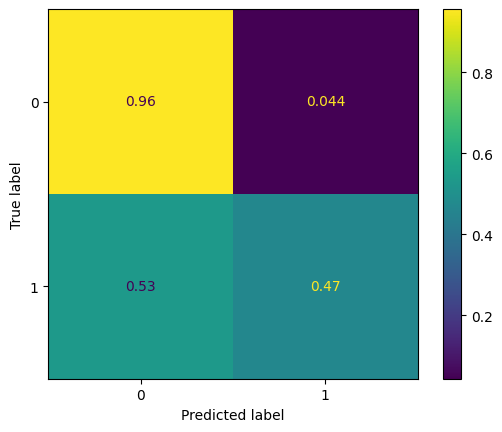

In [31]:
import matplotlib.pyplot as plt

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true'))
conf_matrix.plot()
plt.savefig('reports/cm.png')

In [32]:
f1_score(y_test, y_pred)

0.5697151424287856

In [33]:
roc_auc_score(y_test,y_pred)

0.7114441097491945